# Chick-fil-AI Code

## Dataset

The training dataset is as follows:
* 400 images for both Coccidiosis and Healthy

The testing dataset is as follows:
* 100 images for both Coccidiosis and Healthy

1000 image samples are used in total.

Each image sample is loaded in grayscale.

***

! Cell below is for loading dataset

In [2]:
#--------------------------------------------------------------------------------------------
# Package Imports
#--------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import optimize

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
from PIL import Image

import joblib
from skimage.io import imread
from skimage.transform import resize

import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

#--------------------------------------------------------------------------------------------
# Settings
#--------------------------------------------------------------------------------------------
sns.set(font_scale=1.5)
sns.set_style("dark")
np.set_printoptions(precision=4, suppress=True)

#--------------------------------------------------------------------------------------------
# Loading Data Function
#--------------------------------------------------------------------------------------------
def y_convert(code):
    # 1 -> cocci
    # 2 -> healthy
    
    conversion = {
        0 : "cocci",
        1 : "healthy"
    }
    return conversion[code]

def resize_all(src, pklname, include, width=100, height=None):
    """
>     load images from path, resize them and write them as arrays to a dictionary, 
>     together with labels and metadata. The dictionary is written to a pickle file 
>     named '{pklname}_{width}x{height}px.pkl'.
>      
>     Parameter
>     ---------
>     src: str
>         path to data
>     pklname: str
>         path to output file
>     width: int
>         target width of the image in pixels
>     include: set[str]
>         set containing str
    """
    height = height if height is not None else width
    data = dict()
    data['description'] = 'resized ({0}x{1}) chicken poopie images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []
    
    pklname = f"{pklname}_{width}x{height}px.pkl"
    
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
            
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file), as_gray=True)
                    im = resize(im, (width, height)) #[:,:,::-1]
                    if subdir == "cocci":
                        data['label'].append(0)
                    elif subdir == "healthy":
                        data['label'].append(1)
                    data['filename'].append(file)
                    data['data'].append(im)
                    
        joblib.dump(data, pklname)
        
#--------------------------------------------------------------------------------------------
# Loading Data
#--------------------------------------------------------------------------------------------
test_name = 'poop_test'
train_name = 'poop_train'
width = 100
data_path_test = './data/test_data/'
data_path_train = './data/training_data/'

include = {'cocci', 'healthy'}

# Load Training data
resize_all(src=data_path_train, pklname=train_name, width=width, include=include)
data = joblib.load(f'{train_name}_{width}x{width}px.pkl')

temp1 = np.array(data['data'])
X = temp1.reshape([800, width**2])
temp2 = np.array(data['label'])
y = temp2.reshape([np.shape(temp2)[0], 1])
print(np.shape(X))

resize_all(src=data_path_test, pklname=test_name, width=width, include=include)
data = joblib.load(f'{test_name}_{width}x{width}px.pkl')

temp3 = np.array(data['data'])
X2 = temp3.reshape([200, width**2])
temp4 = np.array(data['label'])
y2 = temp4.reshape([np.shape(temp4)[0], 1])
print(np.shape(X2))

cocci
healthy
(800, 10000)
cocci
healthy
(200, 10000)


## Display Sample Image

Code block below displays a random image from the training set. If data was loaded correctly, then an image will be displayed correctly everytime the code block is ran.

Target: healthy


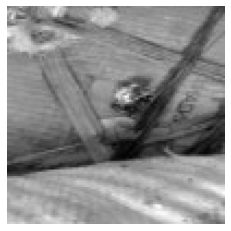

In [10]:
def display_image(sample, ax, width=100, height=100, TRANS=True, scale=10):
  """ Display sample as grayscale image 
  """
  img = sample / max(abs(sample.ravel())) # scale to max
  img = np.reshape(img, (width,height))   # reshape
  if TRANS:
    img = img.T
  img = (img+1) / 2*255               # scale to [0,1], then to [0,255]
  img = Image.fromarray(img.astype(np.uint8))
#   display(img.resize((scale*width, scale*height), Image.NEAREST))
  ax.imshow(img.resize((scale*width, scale*height), Image.NEAREST), cmap='gray')
  plt.axis('off')
  
rng = np.random.default_rng()
index = rng.integers(len(X), size=1)
print("Target:", y_convert(y[index][0][0]))

fig, ax = plt.subplots(1,1)
display_image(X[index,:], ax=ax)

## Helper Functions Implementation

Functions in the code block are as follows:

* Function for hot encoding
* Activation function (sigmoid function)

Some parameters are also initialized below, which are as follows:
* `n_input` is the number of input nodes
* `n_hidden` is the number of nodes in the hidden layer
* `n_output` is the number of output nodes

***
! Run the code block below to load the helper functions

In [11]:
def sigmoid(z):
  """ Sigmoid function """
  return 1.0 / (1.0+np.exp(-z))

def d_sigmoid(z):
  """ Sigmoid derivative function """
  return sigmoid(z) * (1-sigmoid(z));

def hot_encode(y):
  # Convert each target into a multiclass vector for the ANN output layer 

  m = len(y)
  y_hot = np.zeros((m, np.max(y) + 1))
  y_hot[np.arange(m), y.T] = 1
  y_hot = y_hot.T

  return y_hot


# Initialize the neural network
n_input  = 10000;  # 100x100 input images
n_hidden = 50;     # 50 hidden units
n_output = 2;      # 2 labels, from 0 to 1   
m = len(X)         # number of samples

# Hot-encode the labels
y_hot = hot_encode(y)
print(y_hot)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


## Feedforward Algorithm

The function shown below is the feedforward algorithm used in the ANN learning process. The feedforward algorithm below already contains both the cost function and regularization function.

***
! Run the code block below to load the feedforward function

In [12]:
#--------------------------------------------------------------------------------------------
# Feed-forward
#--------------------------------------------------------------------------------------------
def myfeedforward(Theta, args):   
  X, y_hot, n_input, n_hidden, n_output, lmbda = args
  m = len(X) # number of samples 
  Theta1 = Theta[:n_hidden*(n_input+1)].reshape(n_hidden,n_input+1)
  Theta2 = Theta[n_hidden*(n_input+1):].reshape(n_output,n_hidden+1)    
  J = -1 # Cost value
  h_theta = np.zeros((n_output,m))
  Reg = -1

  t1 = Theta1[:,1:]
  t2 = Theta2[:,1:]

  X = np.column_stack([np.ones(m), X])  
  #----------------------------------------------     
  z2 = np.dot(Theta1, np.transpose(X))
  z2 = np.transpose(z2)
  # Compute a2 (size: n_samples x n_hidden+1)
  a2 = sigmoid(z2)
  a2 = np.column_stack([np.ones(m), a2])
  # Compute z3 (size: n_output x n_samples)
  z3 = np.dot(Theta2, np.transpose(a2))
  # 5. Compute a3 / h_theta (same size as a3)
  h_theta = sigmoid(z3)

  J = 0
  for i in range(m):
    for k in range(len(h_theta)):
        J += ((-y_hot[k][i]*(np.log(h_theta[k][i])))-((1-y_hot[k][i])*(np.log(1-h_theta[k][i]))))
  J = J/m
  # Compute the regularization term
  term1 = 0
  term2 = 0

  for i in range(len(Theta1)):
    for j in range(1,len(Theta1[0])):
      term1 += Theta1[i][j]**2

  for i in range(len(Theta2)):
    for j in range(1,len(Theta2[0])):
      term2 += Theta2[i][j]**2

  Reg = (lmbda/(2*m))*(term1 + term2)  
  #----------------------------------------------  
  
  # Regularized cost function
  J = J + Reg;
  return J

## Backpropagation Algorithm

The function shown below is the backpropagation algorithm used in the ANN learning process. The backpropagation algorithm used is the loop version.

***
! Run the code block below to load the backpropagation algorithm

In [13]:
def mybackpropagation(Theta, args):
  """
  Backpropagation algorithm for computing the gradient function with regularization.
  """
  X, y_hot, n_input, n_hidden, n_output, lmbda = args
  m = len(X)  
  Theta1 = Theta[:n_hidden*(n_input+1)].reshape(n_hidden,n_input+1)
  Theta2 = Theta[n_hidden*(n_input+1):].reshape(n_output,n_hidden+1)
  
  X = np.column_stack([np.ones(m), X])  

  # Gradient variables
  Theta1_grad = np.zeros(Theta1.shape);
  Theta2_grad = np.zeros(Theta2.shape);  
  
  # Big delta (accumulated gradients)
  Bigdelta_1 = np.zeros(Theta1.shape);
  Bigdelta_2 = np.zeros(Theta2.shape);  

  #----------------------------------------------      
  for i in range(m):
    a1 = X[i,:]

    
    # 1. Feedforward to compute until a3 (h_theta)     
    z2 = np.dot(Theta1, a1)
    
    a2 = sigmoid(z2)
    a2 = np.concatenate([[1], a2])
    z3 = np.dot(Theta2, a2)
    h_theta = sigmoid(z3)

    
    # 2. Compute delta_3 (1D vector with size n_output)
    delta_3 = h_theta - y_hot.transpose()[i]
    

    # 3. Compute delta_2 (1D vector with size n_hidden)
    z2 = np.insert(z2, 0, 1)   # Add bias before computing delta_2
    temp1 = delta_3.reshape(delta_3.shape+(1,))
    temp2 = d_sigmoid(z2).reshape(d_sigmoid(z2).shape+(1,))
    delta_2 = np.dot(Theta2.transpose(),temp1) * temp2
    
    delta_2 = delta_2[1:]      # Remove bias before computing Bigdelta_1
  # Compute Bigdelta_2, Bigdelta_1 (same size as Theta2, Theta1 resp.)
    
    temp1 = delta_3.reshape(delta_3.shape+(1,))
    temp2 = a2.reshape(a2.shape+(1,))
    Bigdelta_2 += np.dot(temp1, temp2.transpose())
    
    temp1 = a1.reshape(a1.shape+(1,))
    Bigdelta_1 += np.dot(delta_2, temp1.transpose())

  #-------------------
  # #Regularization
  # Compute the regularized gradients
  Theta2_grad = np.zeros(Bigdelta_2.shape);
  for i in range(len(Bigdelta_2)):
    for j in range(len(Bigdelta_2[0])):
        if j == 0:
          Theta2_grad[i][j] = (1/m)*(Bigdelta_2[i][j])
        else:
          Theta2_grad[i][j] = ((1/m)*(Bigdelta_2[i][j]))+((lmbda/m)*(Theta2[i][j]))
        
  Theta1_grad = np.zeros(Bigdelta_1.shape);
  for i in range(len(Bigdelta_1)):
    for j in range(len(Bigdelta_1[0])):
        if j == 0:
          Theta1_grad[i][j] = (1/m)*(Bigdelta_1[i][j])
        else:
          Theta1_grad[i][j] = ((1/m)*(Bigdelta_1[i][j]))+((lmbda/m)*(Theta1[i][j]))

  #---------------------------------------------- 

  # Squeeze the gradients into one vector
  grad = np.append(np.ravel(Theta1_grad), np.ravel(Theta2_grad));
  return grad

## Weight Initialization and Training

The code block below facilitates the training of weights. Weights that have been pretrained will be used to produce the results so running the code block below is for the purpose of reproducing the weight training procedure / creating own weights.

***
! Only run code block below if one wants to produce their own weights (reproduce the pretrained weights)

In [14]:
def init_weights(n_in, n_out, epsilon=0.5):
  """ 
  Initialize weights based on number of incoming and outgoing connections.
  Weights should be within the range [-epsilon, epsilon].
  """
  rng = np.random.default_rng(180) # Seeded randomizer to ensure reproducibility
  W = rng.uniform(-epsilon, epsilon, (n_out, n_in+1))
  return W

def f(Theta, *args):
  """ Optimization function for cost """
  return feedforward(Theta, args)

def gradf(Theta, *args):
  """ Optimization function for gradients """
  return backpropagation(Theta, args)

def print_epoch(Theta):
  """ Epoch updates """
  global epoch, args
  print('Epoch {:>5}:  Cost = {:.4f}'.format(epoch, feedforward(Theta, args)))
  epoch += 1
  
  
#---  
# Initialize random weights
Theta1_init = init_weights(n_input, n_hidden)
Theta2_init = init_weights(n_hidden, n_output)
Theta_init = np.append(np.ravel(Theta1_init), np.ravel(Theta2_init))

# Training ANN settings
epoch = 1
lmbda, maxiter = 3, 200
args = (X, y_hot, n_input, n_hidden, n_output, lmbda)
feedforward, backpropagation = myfeedforward, mybackpropagation

# Train ANN using nonlinear conjugate gradient function
print("ANN Training")
model = optimize.fmin_cg(f, Theta_init, fprime=gradf, args=args, 
                         maxiter=maxiter, callback=print_epoch) 

ANN Training
Epoch     1:  Cost = 79.2646


C:\Users\RAC\AppData\Local\Temp/ipykernel_12652/2820144974.py:3: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0+np.exp(-z))


Epoch     2:  Cost = 39.5264
Epoch     3:  Cost = 31.3885
Epoch     4:  Cost = 31.2240
Epoch     5:  Cost = 29.9567
Epoch     6:  Cost = 23.6718
Epoch     7:  Cost = 23.4125
Epoch     8:  Cost = 23.3521
Epoch     9:  Cost = 2.3644
Epoch    10:  Cost = 1.6276
Epoch    11:  Cost = 1.4337
Epoch    12:  Cost = 1.4174
Epoch    13:  Cost = 1.4111
Epoch    14:  Cost = 1.3884
Epoch    15:  Cost = 1.3657
Epoch    16:  Cost = 1.3373
Epoch    17:  Cost = 1.3028
Epoch    18:  Cost = 1.2639
Epoch    19:  Cost = 1.2453
Epoch    20:  Cost = 1.2059
Epoch    21:  Cost = 1.1492
Epoch    22:  Cost = 1.1323
Epoch    23:  Cost = 1.1258
Epoch    24:  Cost = 1.1183
Epoch    25:  Cost = 1.1114
Epoch    26:  Cost = 1.1088
Epoch    27:  Cost = 1.1031
Epoch    28:  Cost = 1.0933
Epoch    29:  Cost = 1.0818
Epoch    30:  Cost = 1.0740
Epoch    31:  Cost = 1.0545
Epoch    32:  Cost = 1.0402
Epoch    33:  Cost = 1.0285
Epoch    34:  Cost = 1.0022
Epoch    35:  Cost = 0.9876
Epoch    36:  Cost = 0.9807
Epoch    37: 

## Loading Trained Weights

Code block below is for loading own trained weights produced in the previous section.
***
! Only run the code block below when the previous section (Weight Initialization and Training) was ran.

In [15]:
my_Theta1 = model[:n_hidden*(n_input+1)].reshape(n_hidden,n_input+1)
my_Theta2 = model[n_hidden*(n_input+1):].reshape(n_output,n_hidden+1)

## Model Prediction Accuracy Test (Training Dataset)
Code below is for generating a confusion matrix and checking the prediction accuracy of the TRAINING set.
***
! Run code block below to generate the confusion matrix and compute prediction accuracy. Note that the weights used can be interchanged with the pretrained weights or the weights produced earlier.

Training Accuracy: 95.38%


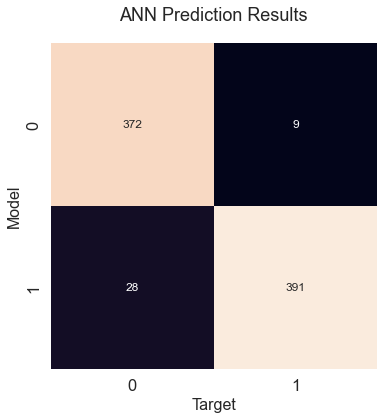

In [31]:
def predict(Theta1, Theta2, X, classes):
  m = len(X)
  num_labels = Theta2.shape[0]
  
  prediction = np.zeros(len(X))
  
  h1 = sigmoid(np.column_stack([np.ones(m), X]) @ Theta1.T)
  h2 = sigmoid(np.column_stack([np.ones(m), h1]) @ Theta2.T)
  
  p = np.argmax(h2, axis=1)
  prediction = np.array([classes[i] for i in p])

  return prediction

def myaccuracy(results):
  """ Compute the classification accuracy of the model 
      accuracy = (# correctly classified) / (# samples)
  """
  acc = -1
  #----------------------------------------------     
  correct = 0
  for i in range(0, len(np.diag(results))):
    correct += np.diag(results)[i]
  samples = 0
  total = np.sum(results)
  for i in range(0, len(total)):
    samples += total.iloc[i]
  acc = correct / samples
  #----------------------------------------------     
  return acc


classes = [0, 1]
  
case = range(len(X))
X_case = np.take(X, case, axis=0)

# Load pretrained weights
Theta1 = joblib.load("theta1.pkl")
Theta2 = joblib.load("theta2.pkl")

## Predict all training samples
# Using pretrained weights
y_model = predict(Theta1, Theta2, X_case, classes)

# Using own weights
#y_model = predict(my_Theta1, my_Theta2, X_case, classes)

y_target = np.take(y, case, axis=0).reshape((-1))

# Generate confusion matrix
y_m = pd.Categorical(y_model, categories=classes)
y_t = pd.Categorical(y_target, categories=classes)
results = pd.crosstab(y_m, y_t, dropna=False)

# Compute accuracy
acc = myaccuracy(results)
print("Training Accuracy: " + str(round(acc*100, 2)) + "%")

# Print confusion matrix
fig, ax = plt.subplots(figsize=(16, 6))
p = sns.heatmap(results, annot=True, ax=ax, cbar=False, 
                annot_kws={"fontsize":12}, fmt='g')
ax.set_aspect('equal')

ax.set_title("ANN Prediction Results", y=1.05)
p.set_xlabel("Target", fontsize=16)
p.set_ylabel("Model", fontsize=16)
plt.show()

## Model Prediction Accuracy Test (Test Dataset)
Code below is for generating a confusion matrix and checking the prediction accuracy of the TEST set. The F-score will also be computed and displayed.
***
! Run code block below to generate the confusion matrix and compute prediction accuracy. Note that the weights used can be interchanged with the pretrained weights or the weights produced earlier.

Test Accuracy: 84.0%
F-score: 0.91


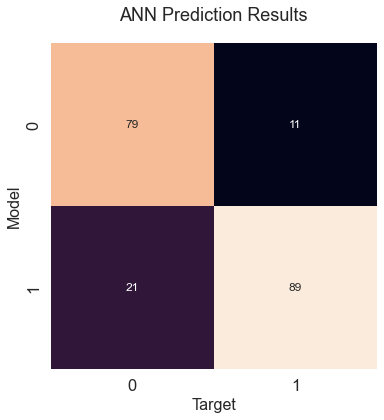

In [32]:
case = range(len(X2))
X_case = np.take(X2, case, axis=0)

## Predict all training samples
# Using pretrained weights
y_model = predict(Theta1, Theta2, X_case, classes)

# Using own weights
#y_model = predict(my_Theta1, my_Theta2, X_case, classes)

y_target = np.take(y2, case, axis=0).reshape((-1))

# Generate confusion matrix
y_m = pd.Categorical(y_model, categories=classes)
y_t = pd.Categorical(y_target, categories=classes)
results = pd.crosstab(y_m, y_t, dropna=False)

# Compute accuracy
acc = myaccuracy(results)
print("Test Accuracy: " + str(round(acc*100, 2)) + "%")

# Compute F-score
TP = 0
for i in range(0, len(np.diag(results))):
    TP += np.diag(results)[i]
    
FP = results.iloc[0][1]
FN = results.iloc[1][0]
fscore = TP / (TP + 0.5 * (FP + FN))
print("F-score: " + str(round(fscore, 2)))

# Print confusion matrix
fig, ax = plt.subplots(figsize=(16, 6))
p = sns.heatmap(results, annot=True, ax=ax, cbar=False, 
                annot_kws={"fontsize":12}, fmt='g')
ax.set_aspect('equal')

ax.set_title("ANN Prediction Results", y=1.05)
p.set_xlabel("Target", fontsize=16)
p.set_ylabel("Model", fontsize=16)
plt.show()